In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
name_col = 'Monthly gasoline demand Ontario gallon millions 1960 ? 1975'

In [2]:
passengers = pd.read_csv('15. monthly-gasoline-demand-ontario.csv', index_col=0, parse_dates=True)

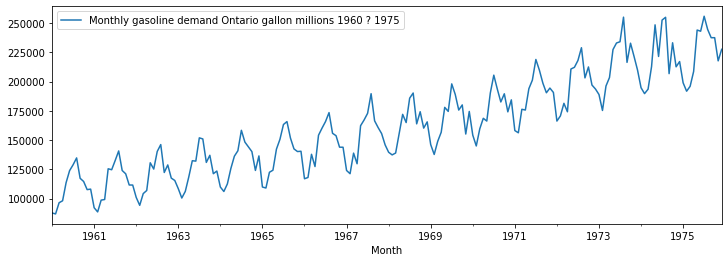

In [3]:
passengers.plot(figsize=(12,4))
plt.show()

In [4]:
from scipy.stats import boxcox, boxcox_llf

In [5]:
passengers_transformed, lmbda = boxcox(passengers['Monthly gasoline demand Ontario gallon millions 1960 ? 1975'])

In [6]:
lmbda

0.23888076085217824

In [7]:
y_transformation = pd.DataFrame(passengers[name_col].values, columns=['initial'])
y_transformation['transformed'] = passengers_transformed

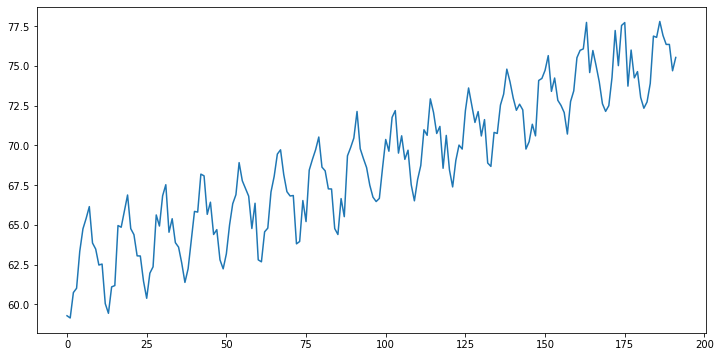

In [8]:
plt.figure(figsize=(12,6))
plt.plot(passengers_transformed)
plt.show()

In [9]:
#очень сезонность и тренд имеются

In [10]:
y_transformation = pd.DataFrame(passengers['Monthly gasoline demand Ontario gallon millions 1960 ? 1975'].values, columns=['initial'])
y_transformation['transformed'] = passengers_transformed

In [11]:
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)

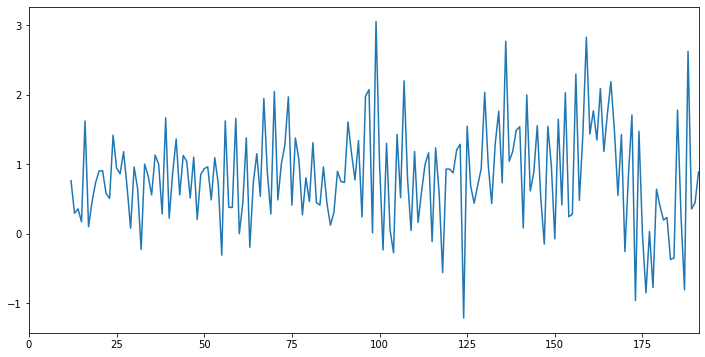

In [12]:
y_transformation['seasonal_diff'].plot(figsize=(12,6))
plt.show()

In [13]:
#похоже на случайным шум.

In [14]:
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

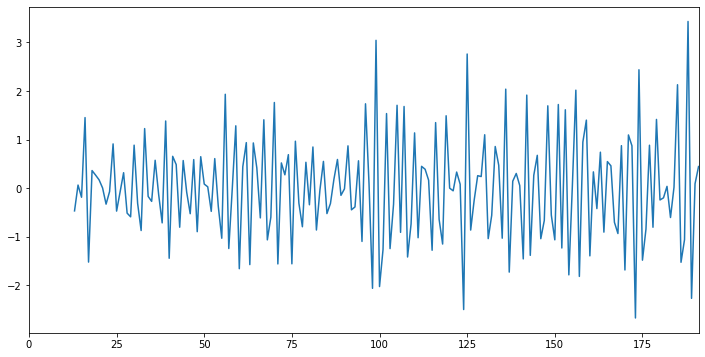

In [15]:
y_transformation['lag1_diff'].plot(figsize=(12,6))
plt.show()

In [16]:
#еще больше похоже на случаным шум

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
# в прежней версии statsmodels.graphics.tsa import plot_acf

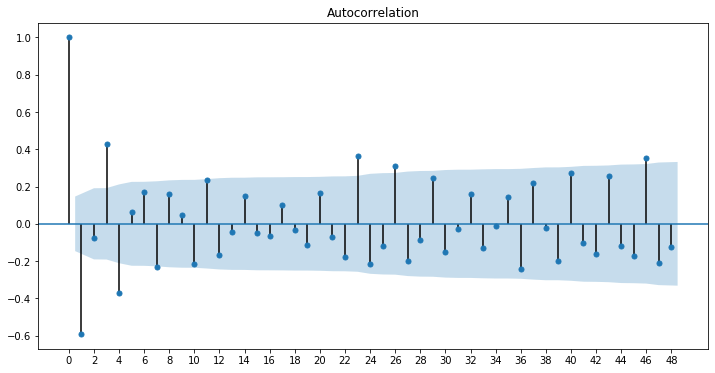

In [18]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
print("Критерий Дики-Фуллера: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера: p=0.000001


In [21]:
data = pd.DataFrame(y_transformation['lag1_diff']).dropna()
data.columns = ['y']

In [22]:
data['y(t-1)'] = data.shift(1)
data['y(t-2)'] = data['y'].shift(2)
data['y(t-12)'] = data['y'].shift(12)

In [23]:
data.head(16)

y    y(t-1)    y(t-2)   y(t-12)
13 -0.468153       NaN       NaN       NaN
14  0.063285 -0.468153       NaN       NaN
15 -0.187525  0.063285 -0.468153       NaN
16  1.452309 -0.187525  0.063285       NaN
17 -1.522232  1.452309 -0.187525       NaN
18  0.361933 -1.522232  1.452309       NaN
19  0.269062  0.361933 -1.522232       NaN
20  0.171202  0.269062  0.361933       NaN
21  0.004644  0.171202  0.269062       NaN
22 -0.329470  0.004644  0.171202       NaN
23 -0.070480 -0.329470  0.004644       NaN
24  0.910592 -0.070480 -0.329470       NaN
25 -0.472751  0.910592 -0.070480 -0.468153
26 -0.082252 -0.472751  0.910592  0.063285
27  0.317725 -0.082252 -0.472751 -0.187525
28 -0.514263  0.317725 -0.082252  1.452309

In [24]:
data.dropna(inplace=True)

In [25]:
data['const'] = 1

In [26]:
def mse(data, params):
    y = data['y']
    y_lag = data.drop('y', axis=1)
    return np.mean((y - np.dot(y_lag, params))**2)

In [28]:
from scipy.optimize import minimize

In [29]:
sarima_results = minimize(lambda x: mse(data, [x[0], x[1], x[2], x[3]]), [0, 0, 0, 0])

In [30]:
sarima_params = sarima_results.x;sarima_params

array([-0.96887801, -0.67360514, -0.08952392, -0.0044807 ])

In [31]:
data.values[-1,1:]

array([ 0.09042574, -2.26867615,  1.41457369,  1.        ])

In [32]:
np.dot(data.values[-1,1:], sarima_params)

1.309461532517309

In [ ]:
#reverse transform

In [33]:
y_transformation.head(15)

initial  transformed  seasonal_diff  lag1_diff
0     87695    59.288476            NaN        NaN
1     86890    59.148799            NaN        NaN
2     96442    60.746611            NaN        NaN
3     98133    61.016786            NaN        NaN
4    113615    63.338897            NaN        NaN
5    123924    64.754508            NaN        NaN
6    128924    65.409004            NaN        NaN
7    134775    66.150806            NaN        NaN
8    117357    63.863633            NaN        NaN
9    114626    63.481950            NaN        NaN
10   107677    62.478550            NaN        NaN
11   108087    62.539100            NaN        NaN
12    92188    60.050629       0.762154        NaN
13    88591    59.442800       0.294001  -0.468153
14    98683    61.103897       0.357286   0.063285

In [39]:
y_transformation['seasonal_diff_shift'] = y_transformation['seasonal_diff'].shift()

In [40]:
y_transformation.head(15)

initial  transformed  seasonal_diff  lag1_diff  seasonal_diff_shift  \
13    88591    59.442800       0.294001  -0.468153                  NaN   
14    98683    61.103897       0.357286   0.063285             0.294001   
15    99207    61.186546       0.169761  -0.187525             0.357286   
16   125485    64.960966       1.622069   1.452309             0.169761   
17   124677    64.854346       0.099838  -1.522232             1.622069   
18   132543    65.870775       0.461771   0.361933             0.099838   
19   140735    66.881639       0.730833   0.269062             0.461771   
20   124008    64.765668       0.902035   0.171202             0.730833   
21   121194    64.388629       0.906679   0.004644             0.902035   
22   111634    63.055760       0.577210  -0.329470             0.906679   
23   111565    63.045829       0.506730  -0.070480             0.577210   
24   101007    61.467951       1.417321   0.910592             0.506730   
25    94228    60.387370       0.944570  -0.472751             1.417321   
26   104255    61.966215       0.862318  -0.082252             0.944570   
27   106922    62.366590       1.180044   0.317725             0.862318   

    transformed_shift  
13          59.148799  
14          60.746611  
15          61.016786  
16          63.338897  
17          64.754508  
18          65.409004  
19          66.150806  
20          63.863633  
21          63.481950  
22          62.478550  
23          62.539100  
24          60.050629  
25          59.442800  
26          61.103897  
27          61.186546

In [41]:
y_transformation['seasonal_diff_res'] = y_transformation['lag1_diff'] + y_transformation['seasonal_diff_shift']

In [42]:
y_transformation.drop(['seasonal_diff_shift'], axis=1, inplace=True)

In [43]:
y_transformation.head(15)

initial  transformed  seasonal_diff  lag1_diff  transformed_shift  \
13    88591    59.442800       0.294001  -0.468153          59.148799   
14    98683    61.103897       0.357286   0.063285          60.746611   
15    99207    61.186546       0.169761  -0.187525          61.016786   
16   125485    64.960966       1.622069   1.452309          63.338897   
17   124677    64.854346       0.099838  -1.522232          64.754508   
18   132543    65.870775       0.461771   0.361933          65.409004   
19   140735    66.881639       0.730833   0.269062          66.150806   
20   124008    64.765668       0.902035   0.171202          63.863633   
21   121194    64.388629       0.906679   0.004644          63.481950   
22   111634    63.055760       0.577210  -0.329470          62.478550   
23   111565    63.045829       0.506730  -0.070480          62.539100   
24   101007    61.467951       1.417321   0.910592          60.050629   
25    94228    60.387370       0.944570  -0.472751          59.442800   
26   104255    61.966215       0.862318  -0.082252          61.103897   
27   106922    62.366590       1.180044   0.317725          61.186546   

    seasonal_diff_res  
13                NaN  
14           0.357286  
15           0.169761  
16           1.622069  
17           0.099838  
18           0.461771  
19           0.730833  
20           0.902035  
21           0.906679  
22           0.577210  
23           0.506730  
24           1.417321  
25           0.944570  
26           0.862318  
27           1.180044

In [44]:
y_transformation['transformed_shift'] = y_transformation['transformed'].shift(12)

In [45]:
y_transformation.dropna(inplace=True)

In [46]:
y_transformation['transformed_res'] = y_transformation['seasonal_diff_res'] + y_transformation['transformed_shift']

In [47]:
y_transformation.drop('transformed_shift', axis=1, inplace=True)

In [48]:
y_transformation.head(10)

initial  transformed  seasonal_diff  lag1_diff  seasonal_diff_res  \
25    94228    60.387370       0.944570  -0.472751           0.944570   
26   104255    61.966215       0.862318  -0.082252           0.862318   
27   106922    62.366590       1.180044   0.317725           1.180044   
28   130621    65.626747       0.665781  -0.514263           0.665781   
29   125251    64.930142       0.075797  -0.589984           0.075797   
30   140318    66.831280       0.960504   0.884707           0.960504   
31   146174    67.528304       0.646665  -0.313839           0.646665   
32   122318    64.540021      -0.225647  -0.872312          -0.225647   
33   128770    65.389137       1.000508   1.226154           1.000508   
34   117518    63.885922       0.830163  -0.170345           0.830163   

    transformed_res  
25        60.387370  
26        61.966215  
27        62.366590  
28        65.626747  
29        64.930142  
30        66.831280  
31        67.528304  
32        64.540021  
33        65.389137  
34        63.885922

In [49]:
def invboxcox(y, lmbda):
    if lmbda != 0:
        return np.exp(np.log(lmbda*y + 1) / lmbda)
    else:
        return np.exp(y)

In [50]:
y_transformation['initial_res'] = invboxcox(y_transformation['transformed_res'], lmbda)

In [55]:
y_transformation.head(30)

initial  transformed  seasonal_diff  lag1_diff  seasonal_diff_res  \
25    94228    60.387370       0.944570  -0.472751           0.944570   
26   104255    61.966215       0.862318  -0.082252           0.862318   
27   106922    62.366590       1.180044   0.317725           1.180044   
28   130621    65.626747       0.665781  -0.514263           0.665781   
29   125251    64.930142       0.075797  -0.589984           0.075797   
30   140318    66.831280       0.960504   0.884707           0.960504   
31   146174    67.528304       0.646665  -0.313839           0.646665   
32   122318    64.540021      -0.225647  -0.872312          -0.225647   
33   128770    65.389137       1.000508   1.226154           1.000508   
34   117518    63.885922       0.830163  -0.170345           0.830163   
35   115492    63.603724       0.557895  -0.272268           0.557895   
36   108497    62.599475       1.131524   0.573629           1.131524   
37   100482    61.386271       0.998901  -0.132623           0.998901   
38   106140    62.249990       0.283775  -0.715126           0.283775   
39   118581    64.032507       1.665917   1.382142           1.665917   
40   132371    65.849048       0.222300  -1.443617           0.222300   
41   132042    65.807427       0.877284   0.654984           0.877284   
42   151938    68.193921       1.362642   0.485357           1.362642   
43   150997    68.086584       0.558280  -0.804362           0.558280   
44   130931    65.666291       1.126269   0.567989           1.126269   
45   137018    66.428683       1.039546  -0.086724           1.039546   
46   121271    64.399034       0.513112  -0.526434           0.513112   
47   123548    64.704482       1.100758   0.587646           1.100758   
48   109894    62.803896       0.204421  -0.896337           0.204421   
49   106061    62.238174       0.851903   0.647482           0.851903   
50   112539    63.185579       0.935589   0.083686           0.935589   
51   125745    64.995164       0.962657   0.027068           0.962657   
52   136251    66.334054       0.485007  -0.477650           0.485007   
53   140892    66.900570       1.093143   0.608137           1.093143   
54   158390    68.916567       0.722646  -0.370497           0.722646   

    transformed_res  initial_res  
25        60.387370      94228.0  
26        61.966215     104255.0  
27        62.366590     106922.0  
28        65.626747     130621.0  
29        64.930142     125251.0  
30        66.831280     140318.0  
31        67.528304     146174.0  
32        64.540021     122318.0  
33        65.389137     128770.0  
34        63.885922     117518.0  
35        63.603724     115492.0  
36        62.599475     108497.0  
37        61.386271     100482.0  
38        62.249990     106140.0  
39        64.032507     118581.0  
40        65.849048     132371.0  
41        65.807427     132042.0  
42        68.193921     151938.0  
43        68.086584     150997.0  
44        65.666291     130931.0  
45        66.428683     137018.0  
46        64.399034     121271.0  
47        64.704482     123548.0  
48        62.803896     109894.0  
49        62.238174     106061.0  
50        63.185579     112539.0  
51        64.995164     125745.0  
52        66.334054     136251.0  
53        66.900570     140892.0  
54        68.916567     158390.0

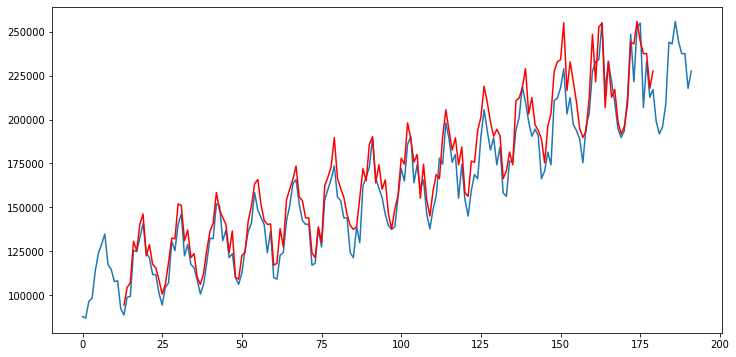

In [54]:
plt.figure(figsize=(12,6))
plt.plot(passengers[name_col].values)
plt.plot(np.concatenate([np.full(13, np.nan), y_transformation['initial_res']]), color='r')
plt.show()